In [1]:
# Cellule 1 : Imports
import numpy as np
import random
import math
import copy
import time
from IPython.display import clear_output, HTML, display, update_display
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

# Fixer la graine pour la reproductibilité
random.seed(56)
np.random.seed(56)

In [2]:
# Cellule 2 : Fonctions utilitaires et Fonction de Coût
def generate_sudoku(n, holes):
    s = math.isqrt(n)
    def pattern(r, c): return (s * (r % s) + r // s + c) % n
    def shuffle(amt): return random.sample(amt, len(amt))
    r_base = range(s)
    rows = [g * s + r for g in shuffle(r_base) for r in shuffle(r_base)]
    cols = [g * s + c for g in shuffle(r_base) for c in shuffle(r_base)]
    nums = shuffle(range(1, n + 1))
    board = [[nums[pattern(r, c)] for c in cols] for r in rows]
    for _ in range(holes):
        board[random.randrange(n)][random.randrange(n)] = 0
    return [val for row in board for val in row]

def get_initial_board(input_string):
    """
    Convertit une chaine de 81 caractères en array numpy 9x9.
    0 représente une case vide.
    """
    if isinstance(input_string, str):
        data = [int(c) for c in input_string]
    else:
        data = input_string
    n = int(len(data)**0.5)
    return np.array(data).reshape((n, n))

def initialize_grid(fixed_board):
    """
    Remplit les cases vides de manière aléatoire MAIS intelligente :
    Chaque bloc 3x3 contiendra exactement les chiffres 1 à 9 une seule fois.
    Cela élimine d'emblée les conflits de blocs, on a juste à gérer lignes/colonnes.
    """
    n = len(fixed_board)
    s = math.isqrt(n)
    current_board = np.copy(fixed_board)
    fixed_mask = (fixed_board != 0) 
    
    for i in range(0, n, s):
        for j in range(0, n, s):
            block = current_board[i:i+s, j:j+s]
            existing = set(block[block != 0])
            missing = [n_val for n_val in range(1, n + 1) if n_val not in existing]
            random.shuffle(missing)
            
            idx = 0
            for r in range(i, i+s):
                for c in range(j, j+s):
                    if current_board[r, c] == 0:
                        current_board[r, c] = missing[idx]
                        idx += 1
                        
    return current_board, fixed_mask

def calculate_energy(board):
    """
    Calcule le nombre d'erreurs.
    L'objectif est 0.
    Score = (Somme des doublons en lignes) + (Somme des doublons en colonnes).
    Pour optimiser : Pour chaque ligne/colonne, Erreur = 9 - (nb valeurs uniques).
    """
    n = len(board)
    score = 0
    for i in range(n):
        score += (n - len(set(board[i, :])))
    for j in range(n):
        score += (n - len(set(board[:, j])))
    return score

def display_sudoku(grid):
    n = len(grid)
    s = math.isqrt(n)
    conflicts = np.zeros((n, n), dtype=bool)
    for i in range(n):
        row = grid[i, :]
        vals, counts = np.unique(row, return_counts=True)
        dupes = vals[(vals != 0) & (counts > 1)]
        conflicts[i, np.isin(row, dupes)] = True
        
        col = grid[:, i]
        vals, counts = np.unique(col, return_counts=True)
        dupes = vals[(vals != 0) & (counts > 1)]
        conflicts[np.isin(col, dupes), i] = True

    for r0 in range(0, n, s):
        for c0 in range(0, n, s):
            block = grid[r0:r0+s, c0:c0+s]
            vals, counts = np.unique(block, return_counts=True)
            dupes = vals[(vals != 0) & (counts > 1)]
            if len(dupes) > 0:
                conflicts[r0:r0+s, c0:c0+s] |= np.isin(block, dupes)
    
    cell_size = max(20, min(40, 800 // n))
    table_w = n * cell_size + (n // s) * 2
    
    html = [f'<div style="display:flex; flex-direction:column; align-items:center; margin:20px auto;">']
    html.append(f'<table style="table-layout:fixed; width:{table_w}px; border:3px solid #000; border-collapse:collapse; background-color:#fff;">')
    
    for r in range(n):
        b_bottom = "3px solid #000" if (r + 1) % s == 0 and r != n - 1 else "1px solid #ddd"
        html.append(f'<tr style="height:{cell_size}px; border-bottom:{b_bottom};">')
        for c in range(n):
            b_right = "3px solid #000" if (c + 1) % s == 0 and c != n - 1 else "1px solid #ddd"
            if conflicts[r, c]:
                bg_color, color = "#fee2e2", "#dc2626"
            else:
                bg_color = "#ffffff" if ((r // s) + (c // s)) % 2 == 0 else "#f9fafb"
                color = "#1f2937"
            
            val = int(grid[r][c])
            val_str = str(val) if val != 0 else ""
            html.append(f'<td style="width:{cell_size}px; height:{cell_size}px; padding:0; text-align:center; vertical-align:middle; '
                        f'border-right:{b_right}; background-color:{bg_color}; color:{color}; font-family:monospace; '
                        f'font-weight:bold; font-size:{cell_size//2}px; line-height:{cell_size}px;">{val_str}</td>')
        html.append('</tr>')
    
    html.append('</table>')
    energy = calculate_energy(grid)
    status = f"Énergie : {energy} {'(Résolu)' if energy == 0 else '(En cours)'}"
    html.append(f'<div style="margin-top:10px; font-family:sans-serif; font-size:14px; font-weight:bold; color:{"#059669" if energy==0 else "#4b5563"}">{status}</div></div>')
    display(HTML("".join(html)))

In [3]:
# Cellule 3 : Le Solveur Monte Carlo
def solve_sudoku_annealing(initial_grid_str, max_steps=None, initial_temp=1.0, cooling_rate=None, infinite_mode=False):
    # 1. Initialisation
    t_start = time.time()
    fixed_board = get_initial_board(initial_grid_str)
    n = len(fixed_board)
    s = math.isqrt(n)
    
    if infinite_mode:
        if cooling_rate is None:
            cooling_rate = 0.99995
        steps_limit = 0
        pbar_total = None
    else:
        if max_steps is None:
            max_steps = int((n**4) * s * 1.2)
        steps_limit = max_steps
        if cooling_rate is None:
            cooling_rate = 1.0 - (6.0 / max_steps)
        pbar_total = max_steps
        
    current_board, fixed_mask = initialize_grid(fixed_board)
    
    current_energy = calculate_energy(current_board)
    initial_energy_val = current_energy
    best_energy = current_energy
    
    temp = initial_temp
    
    display(HTML(f"<div style='margin-bottom:10px;'><b>Énergie initiale :</b> {current_energy}</div>"))

    block_indices = [(i, j) for i in range(0, n, s) for j in range(0, n, s)]
    block_candidates = []
    for bi, bj in block_indices:
        candidates = [(r, c) for r in range(bi, bi+s) for c in range(bj, bj+s) if not fixed_mask[r, c]]
        if len(candidates) >= 2:
            block_candidates.append(candidates)
    
    board = current_board.tolist()
    best_board = [row[:] for row in board]
    
    row_counts = [[0]*(n+1) for _ in range(n)]
    col_counts = [[0]*(n+1) for _ in range(n)]
    for r in range(n):
        for c in range(n):
            val = board[r][c]
            row_counts[r][val] += 1
            col_counts[c][val] += 1

    history_e = [current_energy]
    history_s = [0]
    history_t = [initial_temp]
    history_b = [best_energy]
    
    if infinite_mode:
        plot_update_interval = 5000
        history_interval = 1000
    else:
        plot_update_interval = max(1000, steps_limit // 50)
        history_interval = max(1, steps_limit // 1000)

    """
    fig, ax = plt.subplots(figsize=(6, 3))
    line, = ax.plot(history_s, history_e, color='#dc2626', lw=1.5)
    ax.set_title("Évolution de l'Énergie (Live)", fontsize=10)
    ax.set_xlabel("Itérations", fontsize=8)
    ax.set_ylabel("Erreurs", fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plot_handle = display(fig, display_id="dynamic_plot")
    plt.close(fig)"""

    progress_bar = tqdm(total=pbar_total, desc="Optimisation", unit="it")
    
    _random = random.random
    _choice = random.choice
    _exp = math.exp

    n_accepted = 0
    n_rejected = 0
    n_improved = 0
    n_restarts = 0

    step = 0

    # 2. Boucle de Monte Carlo
    while infinite_mode or step < steps_limit:
        if current_energy == 0:
            progress_bar.close()
            clear_output(wait=True)
            display(HTML(f"<div style='color:green; font-weight:bold; margin-bottom:10px;'>Solution trouvée à l'étape {step}.</div>"))
            return np.array(board), (history_s, history_e, history_t, history_b, time.time()-t_start, initial_energy_val, n_accepted, n_rejected, n_improved, n_restarts, temp, initial_temp, cooling_rate, step, np.sum(fixed_mask))

        candidates = _choice(block_candidates)
        lc = len(candidates)
        idx1 = int(_random() * lc)
        idx2 = int(_random() * (lc - 1))
        if idx2 >= idx1: idx2 += 1
        
        (r1, c1), (r2, c2) = candidates[idx1], candidates[idx2]
        v1, v2 = board[r1][c1], board[r2][c2]
        
        if v1 == v2: 
            n_rejected += 1
            step += 1
            continue

        d_e = 0
        if r1 != r2:
            rc1, rc2 = row_counts[r1], row_counts[r2]
            if rc1[v1] == 1: d_e += 1
            if rc1[v2] == 0: d_e -= 1
            if rc2[v2] == 1: d_e += 1
            if rc2[v1] == 0: d_e -= 1
        if c1 != c2:
            cc1, cc2 = col_counts[c1], col_counts[c2]
            if cc1[v1] == 1: d_e += 1
            if cc1[v2] == 0: d_e -= 1
            if cc2[v2] == 1: d_e += 1
            if cc2[v1] == 0: d_e -= 1

        if d_e <= 0 or (temp > 1e-9 and _exp(-d_e / temp) > _random()):
            if d_e < 0: n_improved += 1
            n_accepted += 1
            board[r1][c1], board[r2][c2] = v2, v1
            row_counts[r1][v1] -= 1; row_counts[r1][v2] += 1
            row_counts[r2][v2] -= 1; row_counts[r2][v1] += 1
            col_counts[c1][v1] -= 1; col_counts[c1][v2] += 1
            col_counts[c2][v2] -= 1; col_counts[c2][v1] += 1
            current_energy += d_e
            
            if current_energy < best_energy:
                best_energy = current_energy
                best_board = [row[:] for row in board]
        else:
            n_rejected += 1
        
        if step % history_interval == 0:
            history_s.append(step)
            history_e.append(current_energy)
            history_t.append(temp)
            history_b.append(best_energy)

        if step % 2000 == 0:
            progress_bar.update(2000)
            if step % 10000 == 0:
                progress_bar.set_postfix({"E": current_energy, "Best": best_energy, "T": f"{temp:.4f}"})
                """if step % plot_update_interval == 0:
                    line.set_xdata(history_s)
                    line.set_ydata(history_e)
                    ax.relim()
                    ax.autoscale_view()
                    plot_handle.update(fig)"""

        temp *= cooling_rate
        
        if temp < 0.005 and current_energy > 0:
            n_restarts += 1
            temp = initial_temp
            board = [row[:] for row in best_board]
            current_energy = best_energy
            row_counts = [[0]*(n+1) for _ in range(n)]
            col_counts = [[0]*(n+1) for _ in range(n)]
            for r in range(n):
                for c in range(n):
                    val = board[r][c]
                    row_counts[r][val] += 1
                    col_counts[c][val] += 1
        
        step += 1

    progress_bar.close()
    clear_output(wait=True)
    display(HTML("<div style='color:red; font-weight:bold; margin-bottom:10px;'>Limite d'itérations atteinte.</div>"))
    return np.array(best_board), (history_s, history_e, history_t, history_b, time.time()-t_start, initial_energy_val, n_accepted, n_rejected, n_improved, n_restarts, temp, initial_temp, cooling_rate, step, np.sum(fixed_mask))

In [33]:
# Cellule 4 : Test
csv_file = "resultats_sudoku_complets.csv"
n_min_sqrt = 8
n_max_sqrt = 9
repetitions_par_n = 25
remplissage_percentages = [95]

if not os.path.isfile(csv_file):
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["N_Size", "Run_ID", "Fixed_Pct", "Success", "Duration", "Iterations", "Energy_Init", "Energy_Final", "Temp_Init", "Temp_Final", "Cooling_Rate", "Restarts", "Accepted", "Rejected", "Improved", "Fixed_Count"])

display(HTML("<h3>Lancement de la campagne de tests intensifs...</h3>"))

for n_sqrt in range(n_min_sqrt, n_max_sqrt + 1):
    n_size = n_sqrt**2
    
    for remplissage_pourcentage in remplissage_percentages:
        holes = int(n_size**2 * (1 - (remplissage_pourcentage / 100)))
        
        for i in range(repetitions_par_n):
            sudoku = generate_sudoku(n_size, holes)
            
            display(HTML(f"<div style='font-family:monospace'>Traitement : Taille {n_size}x{n_size} | Remplissage {remplissage_pourcentage}% | Essai {i+1}/{repetitions_par_n}</div>"))
            
            solution, stats = solve_sudoku_annealing(sudoku, infinite_mode=(n_size > 81))
            s, e, t, b, duration, e_init, n_acc, n_rej, n_imp, n_res, t_end, t_init, c_rate, steps, n_fixed = stats
            
            final_energy = calculate_energy(solution)
            success = (final_energy == 0)
            
            with open(csv_file, mode='a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([n_size, i+1, remplissage_pourcentage, success, duration, steps, e_init, final_energy, t_init, t_end, c_rate, n_res, n_acc, n_rej, n_imp, n_fixed])
                
            clear_output(wait=True)

display(HTML(f"<h3 style='color:green'>Campagne terminée. Toutes les statistiques sont enregistrées dans {csv_file}.</h3>"))

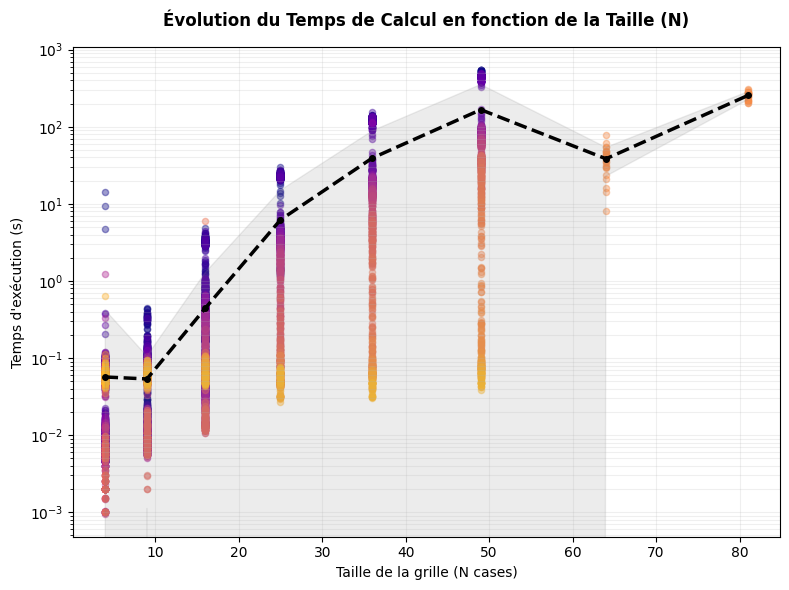

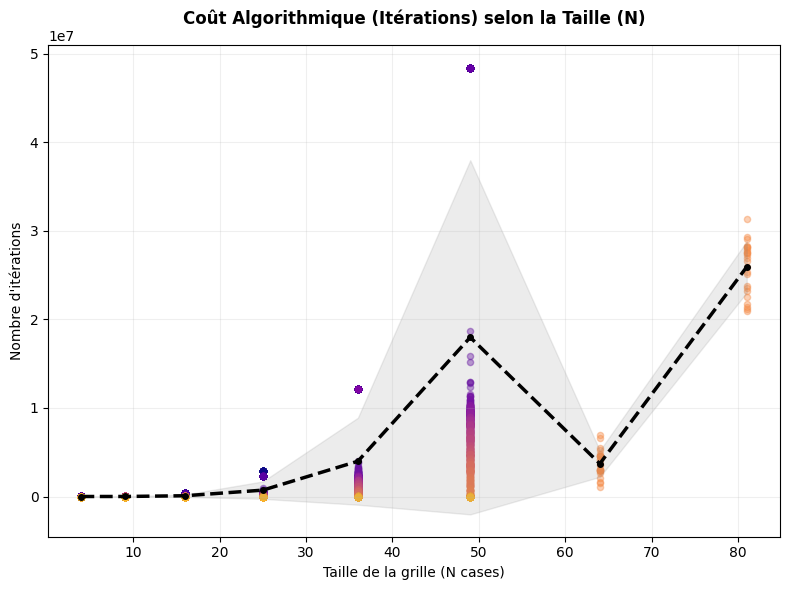

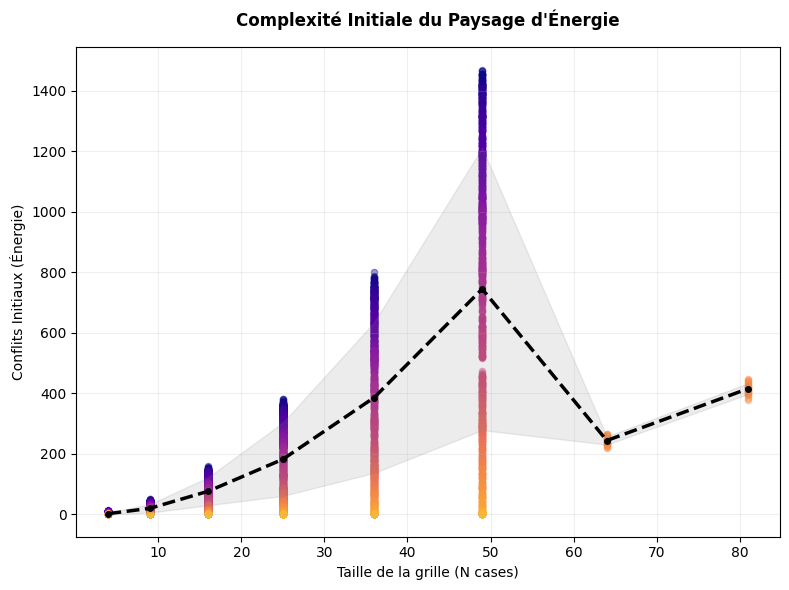

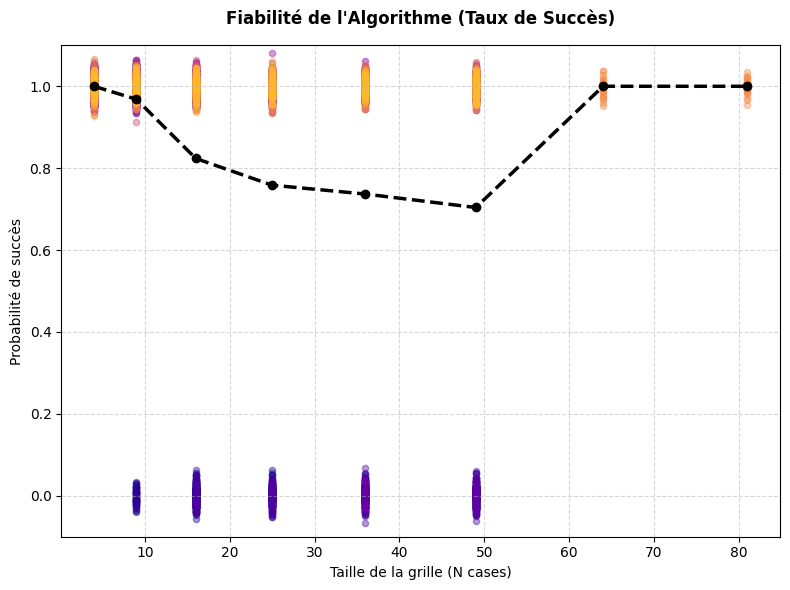

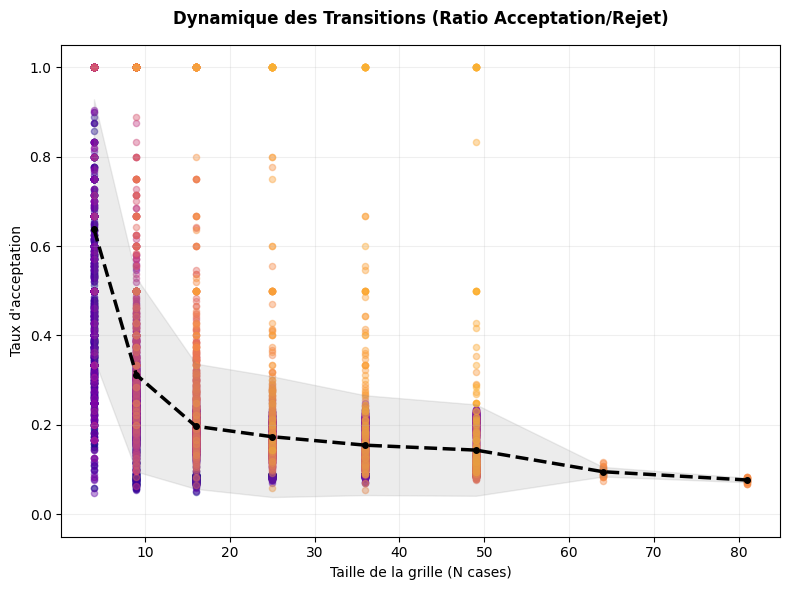

In [6]:
# Cellule 5 : Analyse et Visualisation Scientifique
csv_file = "resultats_sudoku_complets.csv"

try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Le fichier {csv_file} est introuvable. Veuillez lancer la cellule précédente.")
else:
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['grid.linestyle'] = '--'

    df['Success_Int'] = df['Success'].astype(int)
    df['Acceptance_Rate'] = df['Accepted'] / (df['Accepted'] + df['Rejected'])

    def plot_scientific_metric(data, x_col, y_col, y_label, title, log_scale=False, is_rate=False):
        plt.figure(figsize=(8, 6))
        
        unique_pcts = sorted(data['Fixed_Pct'].unique())
        colors = plt.cm.plasma(np.linspace(0, 0.85, len(unique_pcts)))
        
        for idx, pct in enumerate(unique_pcts):
            subset = data[data['Fixed_Pct'] == pct]
            plt.scatter(subset[x_col], subset[y_col], color=colors[idx], alpha=0.4, s=20, label=f'Remplissage {pct}%')

        stats = data.groupby(x_col)[y_col].agg(['mean', 'std']).reset_index()
        plt.plot(stats[x_col], stats['mean'], color='black', linewidth=2.5, linestyle='--', label='Moyenne Globale', marker='o', markersize=4)
        
        plt.fill_between(stats[x_col], 
                         stats['mean'] - stats['std'], 
                         stats['mean'] + stats['std'], 
                         color='gray', alpha=0.15, label='Écart-type Global (1σ)')
        
        plt.xlabel("Taille de la grille (N cases)", fontsize=10)
        plt.ylabel(y_label, fontsize=10)
        plt.title(title, fontweight='bold', pad=15)
        
        if log_scale:
            plt.yscale('log')
            
        if is_rate:
            plt.ylim(-0.05, 1.05)
            
        # plt.legend(frameon=True, fontsize=9, loc='best')
        plt.tight_layout()
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.show()

    plot_scientific_metric(df, 'N_Size', 'Duration', 
                           'Temps d\'exécution (s)', 
                           'Évolution du Temps de Calcul en fonction de la Taille (N)', 
                           log_scale=True)

    plot_scientific_metric(df, 'N_Size', 'Iterations', 
                           'Nombre d\'itérations', 
                           'Coût Algorithmique (Itérations) selon la Taille (N)')

    plot_scientific_metric(df, 'N_Size', 'Energy_Init', 
                           'Conflits Initiaux (Énergie)', 
                           'Complexité Initiale du Paysage d\'Énergie')

    plt.figure(figsize=(8, 6))
    
    unique_pcts = sorted(df['Fixed_Pct'].unique())
    colors = plt.cm.plasma(np.linspace(0, 0.85, len(unique_pcts)))
    
    for idx, pct in enumerate(unique_pcts):
        subset = df[df['Fixed_Pct'] == pct]
        plt.scatter(subset['N_Size'], subset['Success_Int'] + np.random.normal(0, 0.02, len(subset)), 
                    color=colors[idx], alpha=0.4, s=20, label=f'Remplissage {pct}%')

    stats_success = df.groupby('N_Size')['Success_Int'].mean().reset_index()
    plt.plot(stats_success['N_Size'], stats_success['Success_Int'], color='black', linewidth=2.5, linestyle='--', marker='o', label='Moyenne Globale')
    
    plt.xlabel("Taille de la grille (N cases)")
    plt.ylabel("Probabilité de succès")
    plt.title("Fiabilité de l'Algorithme (Taux de Succès)", fontweight='bold', pad=15)
    plt.ylim(-0.1, 1.1)
    # plt.legend(frameon=True, fontsize=9, loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_scientific_metric(df, 'N_Size', 'Acceptance_Rate', 
                           'Taux d\'acceptation', 
                           'Dynamique des Transitions (Ratio Acceptation/Rejet)', is_rate=True)

---